In [71]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [72]:
query =\
'''
SELECT DISTINCT *
FROM (
  SELECT
    phone_number AS user_id,
    SPLIT(main_funding_bank, ',')[SAFE_ORDINAL(1)] AS main_funding_bank,
    -- customer_traffic_bucket
  FROM `ledger-fcc1e.temp_rachel.merchant_profiling_data_for_mse_prioritization_v2`
)
LEFT JOIN (
  SELECT
    phone_number_clean AS user_id,
    M0_core_count,
    M0_ppob_payment_count
  FROM `ledger-fcc1e.dg_buku_trnsfmd.EDC_BW_userbase_all`
) USING (user_id)
LEFT JOIN (
  SELECT
    user_id,
    acquisition_channel,
    -- user_segment_bucket,
    -- age_on_platform_days
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
) USING (user_id)

'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/raw_data.pkl')
raw = pd.read_pickle('data/raw_data.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [73]:
# -- QUERY TO GET IMPRESSIONS COUNT
imp_query =\
'''
SELECT 
  user_id,
  IFNULL(impressions_count, 0) AS impressions_count,
  IFNULL(read_count, 0) AS read_count,
FROM (
  SELECT
    phone_number AS user_id,
    -- SPLIT(main_funding_bank, ',')[SAFE_ORDINAL(1)] AS main_funding_bank,
    -- customer_traffic_bucket
  FROM `ledger-fcc1e.temp_rachel.merchant_profiling_data_for_mse_prioritization_v2`
)
LEFT JOIN (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE notification_date BETWEEN '2023-08-01' AND '2023-08-31'
  GROUP BY 1
) USING (user_id)
'''
imp = client.query(imp_query).result().to_dataframe()
imp.to_pickle('data/raw_imp_data.pkl')
imp = pd.read_pickle('data/raw_imp_data.pkl')

In [74]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                8032 non-null   object
 1   main_funding_bank      6171 non-null   object
 2   M0_core_count          7403 non-null   Int64 
 3   M0_ppob_payment_count  7403 non-null   Int64 
 4   acquisition_channel    7779 non-null   object
dtypes: Int64(2), object(3)
memory usage: 329.6+ KB


In [75]:
# df = raw

df =\
(
    raw
    .assign(
        M0_core_count = lambda x: np.log1p(x.M0_core_count.fillna(0)),
        M0_ppob_payment_count = lambda x: np.log1p(x.M0_ppob_payment_count.fillna(0))
    )
)

# tpv_col = df.filter(regex='TPV|tpv').columns
# for i in tpv_col:
#     df[i] = pd.to_numeric(df[i])

# # normalize the numeric columns
# num_col = [col for col in df.select_dtypes(include=['float', 'int']).columns if '_flag' not in col]
# num_col = [col for col in df[num_col].columns if 'age' not in col]
# for i in num_col:
#     df[i] = df[i].fillna(0).apply(np.log1p)

# # turn object columns to dummy
# # df = pd.get_dummies(data=df, columns=['acquisition_channel', 'kyc_tier', 'loyalty_tier'], prefix=['pm_acq', 'pm_kyc', 'pm_lyl'], dtype=bool)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8032 non-null   object 
 1   main_funding_bank      6171 non-null   object 
 2   M0_core_count          8032 non-null   Float64
 3   M0_ppob_payment_count  8032 non-null   Float64
 4   acquisition_channel    7779 non-null   object 
dtypes: Float64(2), object(3)
memory usage: 329.6+ KB


In [77]:
s = setup(
    df, 
    normalize=True, 
    ignore_features='user_id',
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(8032, 5)"
2,Transformed data shape,"(8032, 13)"
3,Ignore features,7
4,Numeric features,2
5,Categorical features,2
6,Rows with missing values,25.2%
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [78]:
kmeans = create_model('kmeans', num_clusters=9)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7530,3015.5969,0.3539,0,0,0


In [79]:
plot_model(kmeans, 'cluster')

In [80]:
plot_model(kmeans, 'tsne')

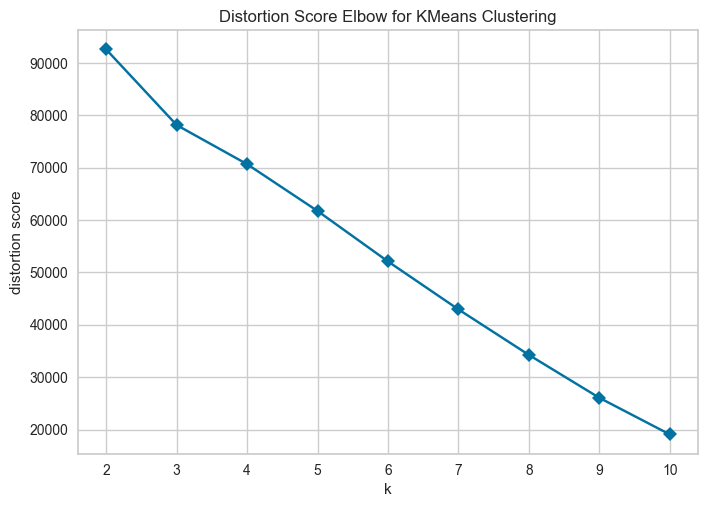

In [81]:
plot_model(kmeans, 'elbow')

In [82]:
results = assign_model(kmeans)

In [83]:
results

,main_funding_bank,M0_core_count,M0_ppob_payment_count,acquisition_channel,Cluster
0,BNII,0.0,1.098612,Offline Acquisition,Cluster 0
1,NaN,0.0,0.0,Offline Acquisition,Cluster 1
2,BRI,0.0,0.0,Offline Acquisition,Cluster 1
3,BRI,0.0,0.0,Offline Acquisition,Cluster 1
4,BNI,0.0,0.0,Offline Acquisition,Cluster 8
...,...,...,...,...,...
8027,BRI,0.0,0.0,Offline Acquisition,Cluster 1
8028,BRI,0.0,0.0,Offline Acquisition,Cluster 1
8029,BRI,0.0,2.397895,Offline Acquisition,Cluster 1
8030,BCA,0.0,0.0,Offline Acquisition,Cluster 2


In [84]:
res = results.merge(imp, how='left', on='user_id')

KeyError: 'user_id'